# Variational Autoencoders 


### References

[1] Diederik P. Kingma, Danilo J. Rezende, Shakir Mohamed, Max Welling, https://arxiv.org/pdf/1406.5298.pdf

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Reshape, LeakyReLU, Lambda 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.reshape(x_train.astype('float32') / 255., (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test.astype('float32') / 255., (len(x_test), 28, 28, 1))


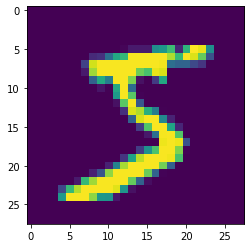

In [17]:
plt.imshow(x_train[0])

In [18]:
def make_encoder(input_dim: int, latent_dim: int):
    encoder_inputs = keras.Input(shape=(input_dim, input_dim, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder

def make_decoder(latent_dim: int):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return decoder

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }






In [19]:
(x_train, y_train), (x_test, y_train) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

encoder = make_encoder(28, 2)
decoder = make_decoder(2)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_3 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [20]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

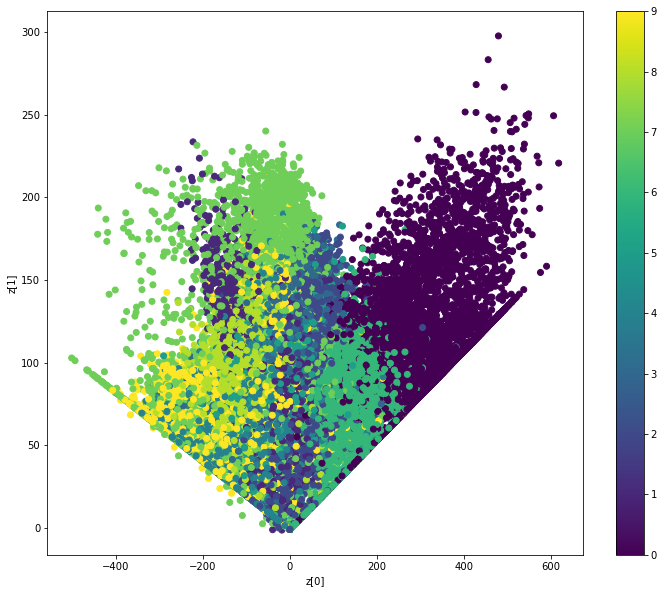

In [21]:
plot_label_clusters(vae, x_train, y_train)